라이브러리 Import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# 그래프 설정 (시각화 스타일)
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False



데이터셋 다운로드

> 40만개의 날씨 데이터(2009~2016)



In [5]:
import urllib.request
import zipfile
import os

zip_url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip'
zip_path = 'jena_climate_2009_2016.csv.zip'
csv_path = 'jena_climate_2009_2016.csv'

# 다운로드
if not os.path.exists(zip_path):
    print("Downloading dataset...")
    urllib.request.urlretrieve(zip_url, zip_path)
    print("Download complete.")
else:
    print("Dataset already downloaded.")

# 압축 해제
if not os.path.exists(csv_path):
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Extraction complete.")
else:
    print("CSV file already exists.")


Dataset already downloaded.
CSV file already exists.


데이터 로드 및 확인

> .head()를 통해 5개의 데이터를 순서대로 출력



In [6]:
import pandas as pd

df = pd.read_csv('jena_climate_2009_2016.csv')  # 이미 추출된 CSV 파일 경로
print(df.head())  # 상위 5개 행 출력


             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03        

데이터셋을 학습 데이터와 라벨 데이터로 변환

> history_size : 우리가 볼 수 있는 데이터의 크기
  target_size : 우리가 예측할 데이터 크기



In [7]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)


Train set과 Vallidation set을 나눌 기준 변수 설정

> 40만 개의 데이터를 Train 30만, Val 10만으로 분할



In [8]:
TRAIN_SPLIT = 300000

온도 변화량 시계열 예측

In [9]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
print(uni_data.head())

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64


전체 데이터를 그래프로 확인

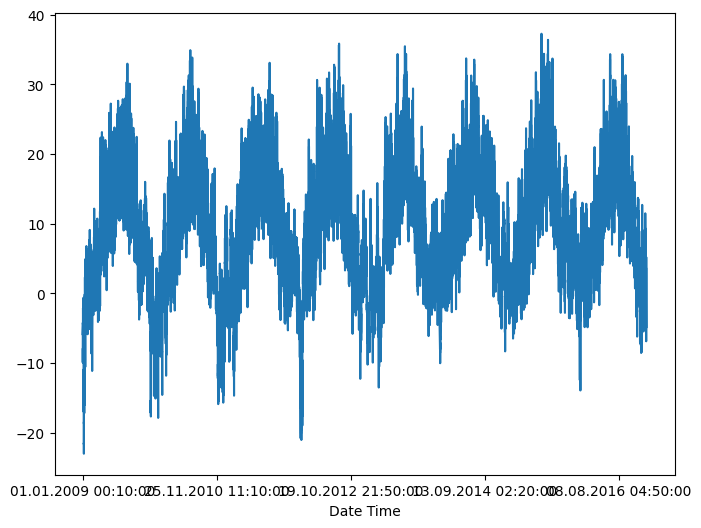

In [10]:
uni_data.plot(subplots=True)
plt.show()

학습 데이터 생성

> 데이터셋을 평균과 표준편차로 Normalization




In [11]:
uni_data = uni_data.values

uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std

과거 20개의 데이터를 보고 바로 뒤에 미래를 예측하도록 데이터 생

In [12]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

학습 데이터 생성 및 샘플 데이터 확인

In [13]:
print ('Single window of past history')
print (x_train_uni[10])
print ('\n Target temperature to predict')
print (y_train_uni[10])

Single window of past history
[[-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]
 [-2.10418486]
 [-2.09492208]
 [-2.10997409]
 [-2.11692118]
 [-2.13776242]
 [-2.16786644]
 [-2.16902429]
 [-2.15165658]
 [-2.16555075]
 [-2.1840763 ]]

 Target temperature to predict
-2.1887076840252155


온도 변화량 시계열 예측

In [14]:
def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

In [15]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                     label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    plt.show()
    return plt

그래프로 샘플 데이터 확인

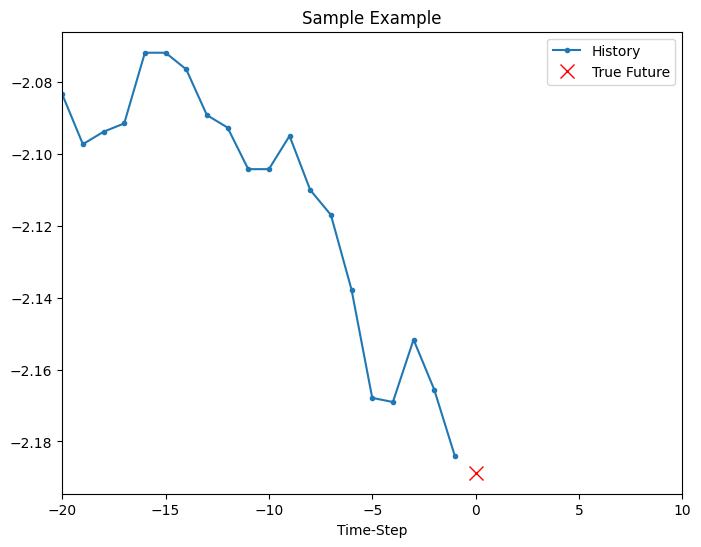

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

In [16]:
show_plot([x_train_uni[10], y_train_uni[10]], 0, 'Sample Example')

온도 변화량 시계열 예측

> 베이스라인(과거 데이터 평균)과 앞으로 학습할 신경망 비교



In [17]:
def baseline(history):
    return np.mean(history)

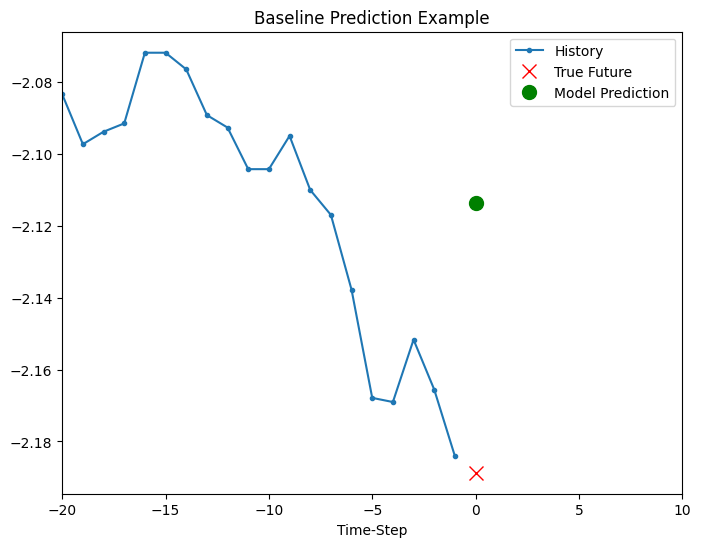

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

In [18]:
show_plot([x_train_uni[10], y_train_uni[10], baseline(x_train_uni[10])], 0,
           'Baseline Prediction Example')

PyTorch DataLoader를 사용해 데이터셋을 셔플하고 미니batch로 구성


In [19]:
import torch
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 256

# NumPy → Tensor로 변환
x_train_tensor = torch.tensor(x_train_uni, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_uni, dtype=torch.float32)

x_val_tensor = torch.tensor(x_val_uni, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_uni, dtype=torch.float32)

# TensorDataset 생성
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# DataLoader로 배치 처리 & 셔플
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)


PyTorch의 LSTM 계층을 사용하여 시계열 예측 모델 생성

In [20]:
import torch
import torch.nn as nn

class SimpleLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=8, output_size=1):
        super(SimpleLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_len, hidden_size)
        last_output = lstm_out[:, -1, :]  # 마지막 시점 hidden state
        return self.fc(last_output)       # 예측값 (batch_size, output_size)


Optimizer와 Loss 정의

In [21]:
model = SimpleLSTMModel()
criterion = nn.L1Loss()                   # MAE (mean absolute error)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


샘플로 출력 확인

In [22]:
# 모델을 평가 모드로 전환
model.eval()

# val_loader에서 샘플 배치 가져오기
for x, y in val_loader:
    with torch.no_grad():  # 그래디언트 계산 비활성화 (inference)
        output = model(x)
        print("예측 결과 shape:", output.shape)
    break  # 한 배치만 확인


예측 결과 shape: torch.Size([256, 1])


LSTM 모델 학습

In [23]:
EPOCHS = 10
EVALUATION_INTERVAL = 200  # 학습 배치 반복 횟수

model.train()  # 학습 모드 전환

for epoch in range(EPOCHS):
    running_loss = 0.0
    for step, (x_batch, y_batch) in enumerate(train_loader):
        # 순전파
        output = model(x_batch)
        loss = criterion(output.squeeze(), y_batch)

        # 역전파 및 옵티마이저 스텝
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # 일정 간격마다 평가
        if step % EVALUATION_INTERVAL == 0:
            model.eval()
            val_losses = []
            with torch.no_grad():
                for x_val_batch, y_val_batch in val_loader:
                    val_pred = model(x_val_batch)
                    val_loss = criterion(val_pred.squeeze(), y_val_batch)
                    val_losses.append(val_loss.item())
            avg_train_loss = running_loss / (step + 1)
            avg_val_loss = sum(val_losses) / len(val_losses)
            print(f"[Epoch {epoch+1}] Step {step} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
            model.train()


[Epoch 1] Step 0 | Train Loss: 0.9155 | Val Loss: 0.8262
[Epoch 1] Step 200 | Train Loss: 0.5587 | Val Loss: 0.1633
[Epoch 1] Step 400 | Train Loss: 0.3304 | Val Loss: 0.0592
[Epoch 1] Step 600 | Train Loss: 0.2362 | Val Loss: 0.0378
[Epoch 1] Step 800 | Train Loss: 0.1856 | Val Loss: 0.0294
[Epoch 1] Step 1000 | Train Loss: 0.1541 | Val Loss: 0.0259
[Epoch 2] Step 0 | Train Loss: 0.0245 | Val Loss: 0.0236
[Epoch 2] Step 200 | Train Loss: 0.0233 | Val Loss: 0.0218
[Epoch 2] Step 400 | Train Loss: 0.0225 | Val Loss: 0.0206
[Epoch 2] Step 600 | Train Loss: 0.0219 | Val Loss: 0.0197
[Epoch 2] Step 800 | Train Loss: 0.0214 | Val Loss: 0.0190
[Epoch 2] Step 1000 | Train Loss: 0.0209 | Val Loss: 0.0180
[Epoch 3] Step 0 | Train Loss: 0.0169 | Val Loss: 0.0183
[Epoch 3] Step 200 | Train Loss: 0.0179 | Val Loss: 0.0171
[Epoch 3] Step 400 | Train Loss: 0.0176 | Val Loss: 0.0166
[Epoch 3] Step 600 | Train Loss: 0.0174 | Val Loss: 0.0165
[Epoch 3] Step 800 | Train Loss: 0.0173 | Val Loss: 0.0159
[

학습한 LSTM 모델로 몇몇 샘플에 대한 예측 실행

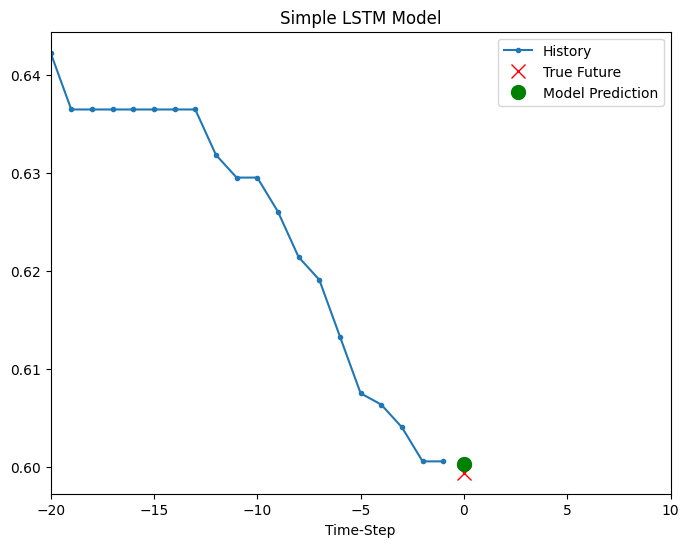

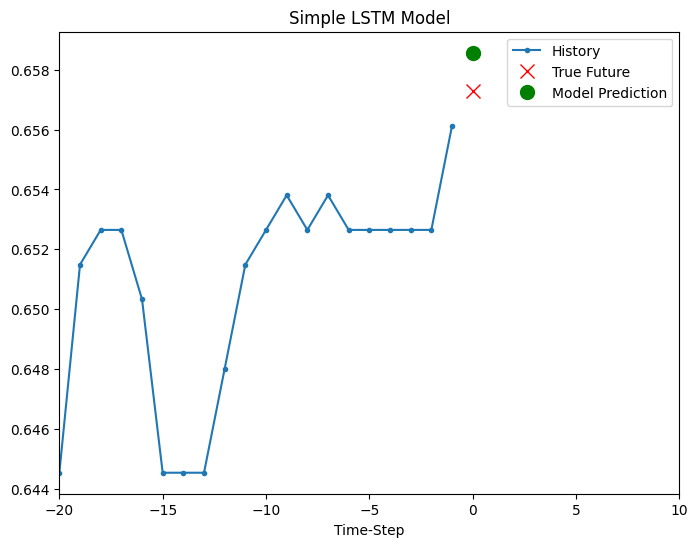

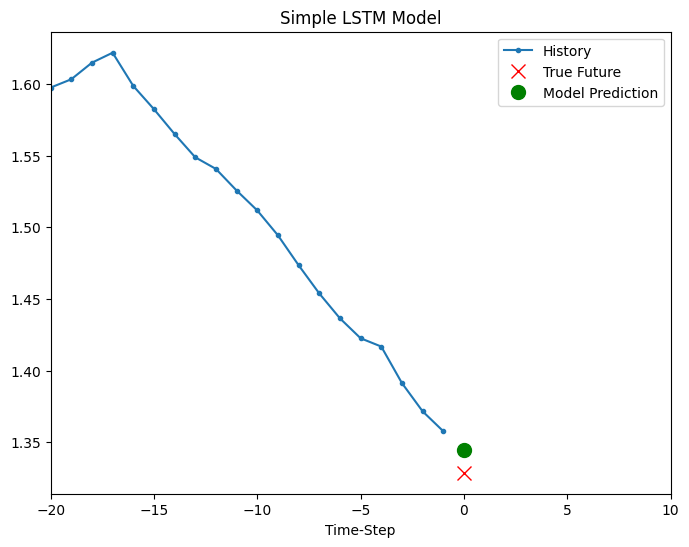

In [24]:
model.eval()  # 평가 모드 전환

# val_loader에서 3개의 배치만 추출해서 예측 & 시각화
for step, (x_batch, y_batch) in enumerate(val_loader):
    if step >= 3:
        break

    with torch.no_grad():
        prediction = model(x_batch)  # shape: (batch_size, 1)

    # 첫 번째 샘플만 시각화
    x_sample = x_batch[0].numpy()
    y_sample = y_batch[0].item()
    pred_sample = prediction[0].item()

    show_plot([x_sample, y_sample, pred_sample], delta=0, title='Simple LSTM Model')


온도뿐만 아니라 대기압, 공기 밀도 데이터를 추가로 사용

In [25]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

features = df[features_considered]
features.index = df['Date Time']
print(features.head())

                     p (mbar)  T (degC)  rho (g/m**3)
Date Time                                            
01.01.2009 00:10:00    996.52     -8.02       1307.75
01.01.2009 00:20:00    996.57     -8.41       1309.80
01.01.2009 00:30:00    996.53     -8.51       1310.24
01.01.2009 00:40:00    996.51     -8.31       1309.19
01.01.2009 00:50:00    996.51     -8.27       1309.00


선택한 데이터들을 그래프로 확인

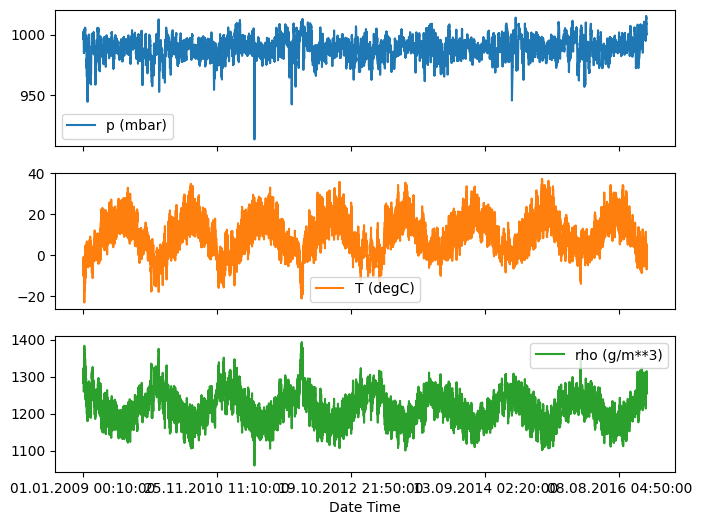

In [26]:
features.plot(subplots=True)
plt.show()

학습 데이터 생성

In [30]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

In [27]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

12시간 뒤(10분*72개 후)의 데이터를 예측하도록 데이터 생성

In [31]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [32]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


다변량 시계열 예측을 위한 DataLoader 구성

In [33]:
from torch.utils.data import TensorDataset, DataLoader

# 넘파이 배열을 텐서로 변환
x_train_tensor = torch.tensor(x_train_single, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_single, dtype=torch.float32)

x_val_tensor = torch.tensor(x_val_single, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_single, dtype=torch.float32)

# TensorDataset 생성
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# DataLoader로 셔플하고 배치 구성
BATCH_SIZE = 256
BUFFER_SIZE = 10000  # PyTorch에서는 사용 안됨

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)


In [37]:
import torch.nn as nn

class MultivariateSingleStepLSTM(nn.Module):
    def __init__(self, input_size=3, hidden_size=32):
        super(MultivariateSingleStepLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Dense layer

    def forward(self, x):
        out, _ = self.lstm(x)  # out: (batch, seq_len, hidden_size)
        out = out[:, -1, :]    # 마지막 타임스텝의 hidden state만 사용
        out = self.fc(out)     # shape: (batch, 1)
        return out

model = MultivariateSingleStepLSTM(input_size=3, hidden_size=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()  # MAE


In [38]:
model.eval()  # 평가 모드 전환

# 검증 배치 하나 가져오기
for x_batch, y_batch in val_loader:
    with torch.no_grad():
        pred = model(x_batch)  # 예측 결과: (batch_size, 1)
    print(pred.shape)
    break  # 한 번만 실행 (take(1) 역할)


torch.Size([256, 1])


LSTM 모델 학습

In [44]:
import torch
import matplotlib.pyplot as plt

EPOCHS = 10
EVALUATION_INTERVAL = 200  # steps_per_epoch
VAL_STEPS = 50

# 🔥 손실 리스트 선언 (그래프용)
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for i, (x_batch, y_batch) in enumerate(train_loader):
        if i >= EVALUATION_INTERVAL:
            break

        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output.squeeze(), y_batch)  # y_batch shape: (batch,)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # 🔍 검증
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for j, (x_val, y_val) in enumerate(val_loader):
            if j >= VAL_STEPS:
                break
            val_pred = model(x_val)
            loss = criterion(val_pred.squeeze(), y_val)
            val_loss += loss.item()

    # 🔥 에폭당 평균 손실 계산
    avg_train_loss = train_loss / EVALUATION_INTERVAL
    avg_val_loss = val_loss / VAL_STEPS

    # ✅ 리스트에 저장 (그래프용)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

Epoch 1/10 | Train Loss: 0.2467 | Val Loss: 0.2363
Epoch 2/10 | Train Loss: 0.2457 | Val Loss: 0.2337
Epoch 3/10 | Train Loss: 0.2448 | Val Loss: 0.2326
Epoch 4/10 | Train Loss: 0.2431 | Val Loss: 0.2321
Epoch 5/10 | Train Loss: 0.2421 | Val Loss: 0.2311
Epoch 6/10 | Train Loss: 0.2410 | Val Loss: 0.2303
Epoch 7/10 | Train Loss: 0.2411 | Val Loss: 0.2386
Epoch 8/10 | Train Loss: 0.2384 | Val Loss: 0.2346
Epoch 9/10 | Train Loss: 0.2374 | Val Loss: 0.2362
Epoch 10/10 | Train Loss: 0.2372 | Val Loss: 0.2307


학습 Loss 표시

In [45]:
def plot_train_history(train_losses, val_losses, title):
    epochs = range(len(train_losses))

    plt.figure()
    plt.plot(epochs, train_losses, 'bo-', label='Training loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
    plt.ylim(min(min(train_losses), min(val_losses)) - 0.02,
             max(max(train_losses), max(val_losses)) + 0.02)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

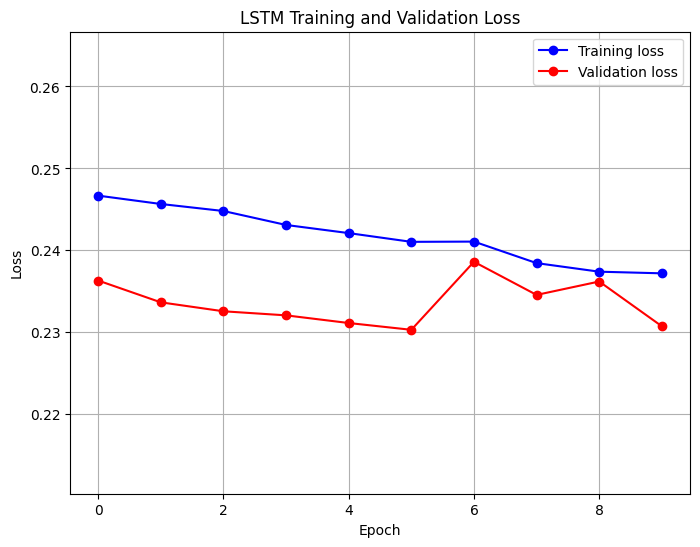

In [46]:
plot_train_history(train_losses, val_losses, "LSTM Training and Validation Loss")

다변량 시계열 데이터 학습 후 모델로 샘플 예측

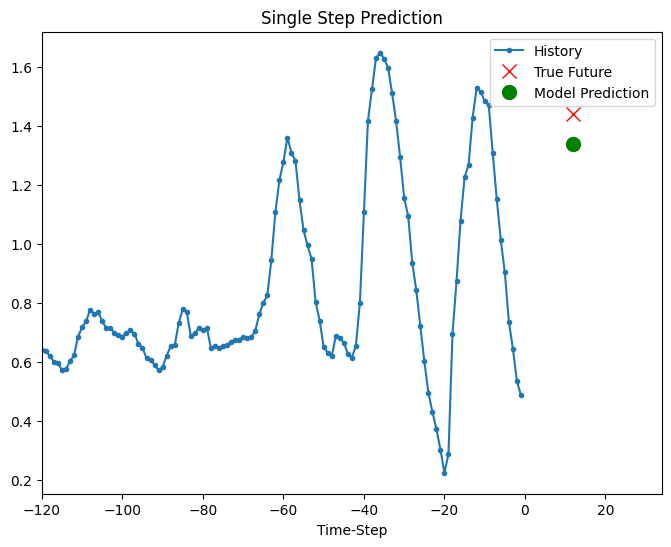

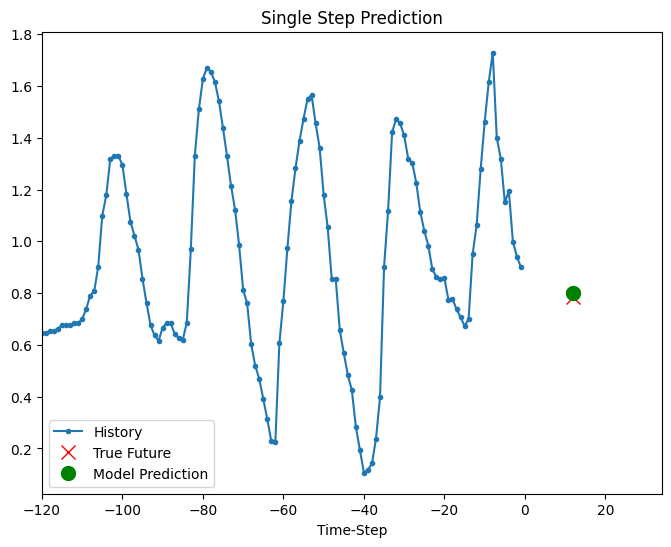

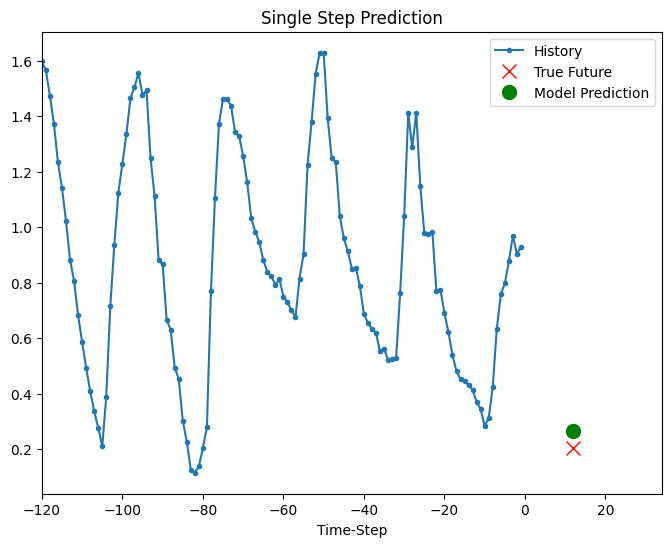

In [47]:
# PyTorch용 예측 및 시각화 코드 (3개 샘플만 예측해 시각화)
model.eval()
count = 0

with torch.no_grad():
    for x_batch, y_batch in val_loader:
        if count >= 3:
            break

        # 배치에서 첫 샘플만 시각화
        x_sample = x_batch[0]  # shape: [seq_len, num_features]
        y_sample = y_batch[0]  # shape: [1]

        # 예측
        pred = model(x_batch)[0].item()

        # 온도값만 추출 (두 번째 피처 = 온도)
        history_temp = x_sample[:, 1].numpy()
        true_value = y_sample.item()
        predicted_value = pred

        # 시각화
        show_plot([history_temp, true_value, predicted_value], 12, 'Single Step Prediction')
        count += 1


다변량 시계열 예측 - 여러 시간 지점의 미래를 예측

> 입력: 과거 5일치 데이터를 1시간 간격(STEP=6)으로 추출 (즉, 총 120개 시계열 포인트)

> 출력: 12시간(=72개, 10분 간격)의 미래 온도 예측



In [48]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


다변량 시계열 예측을 위한 DataLoader 구성

In [53]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# 넘파이 → 텐서 변환
x_train_multi_tensor = torch.tensor(x_train_multi, dtype=torch.float32)
y_train_multi_tensor = torch.tensor(y_train_multi, dtype=torch.float32)

x_val_multi_tensor = torch.tensor(x_val_multi, dtype=torch.float32)
y_val_multi_tensor = torch.tensor(y_val_multi, dtype=torch.float32)

# TensorDataset 생성
train_dataset_multi = TensorDataset(x_train_multi_tensor, y_train_multi_tensor)
val_dataset_multi = TensorDataset(x_val_multi_tensor, y_val_multi_tensor)

# DataLoader로 셔플 및 배치 처리
BATCH_SIZE = 256

train_loader_multi = DataLoader(train_dataset_multi, batch_size=BATCH_SIZE, shuffle=True)
val_loader_multi = DataLoader(val_dataset_multi, batch_size=BATCH_SIZE, shuffle=False)


In [57]:
def create_time_steps(length):
    return list(range(-length, 0))  # 과거 시점: -120 ~ -1 등

def multi_step_plot(history, true_future, prediction=None, step=1):
    """
    history: (seq_len, num_features) → 과거 입력
    true_future: (target_len,) → 실제 미래 시계열
    prediction: (target_len,) → 예측된 미래 시계열
    step: STEP 값 (예: 6 → 1시간 단위)
    """
    plt.figure(figsize=(12, 6))

    num_in = create_time_steps(len(history))         # 입력 시점 축: 음수 시간
    num_out = np.arange(len(true_future)) / step     # 미래 시점 축: 0부터 시작

    # 온도 히스토리 (2번째 피처 = 'T (degC)')
    plt.plot(num_in, history[:, 1], label='History')

    # 실제 미래 값
    plt.plot(num_out, true_future, 'bo', label='True Future')

    # 예측된 미래 값 (있을 경우)
    if prediction is not None and len(prediction) > 0:
        plt.plot(num_out, prediction, 'ro', label='Predicted Future')

    plt.xlabel('Time Step')
    plt.ylabel('Temperature')
    plt.title('Multi-step Forecast')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()


샘플 데이터 출력

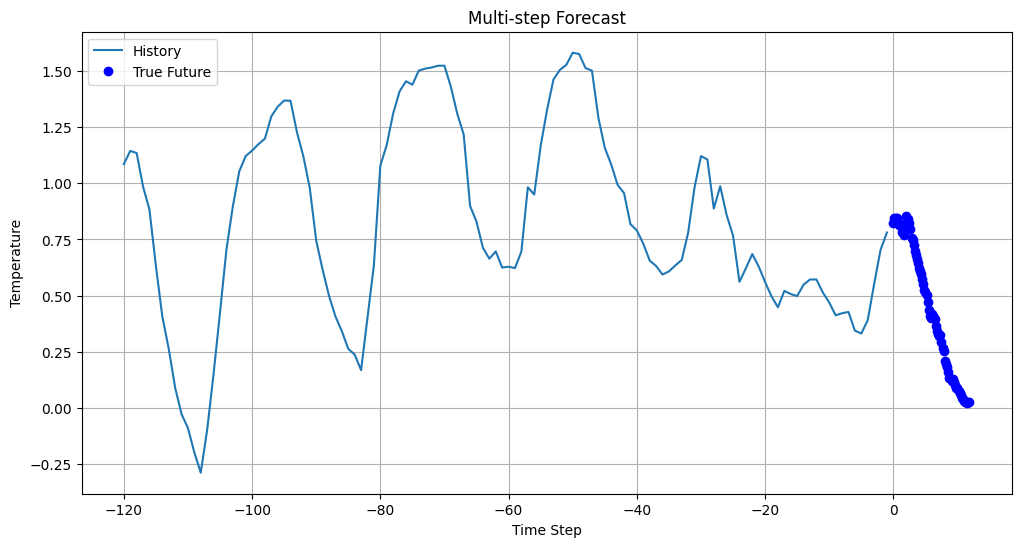

In [58]:
# 샘플 데이터 시각화 (예측 없이 히스토리 + 실제 미래만)
for x_batch, y_batch in train_loader_multi:
    x_sample = x_batch[0]  # shape: (120, 3)
    y_sample = y_batch[0]  # shape: (72,)

    # NumPy 변환 후 시각화
    multi_step_plot(
        history=x_sample.cpu().numpy(),
        true_future=y_sample.cpu().numpy(),
        prediction=np.array([]),  # 예측 없이 빈 배열 전달
        step=STEP
    )
    break  # 한 샘플만 출력


LSTM 신경망 모델 생성

> 72개 미래 예측을 위한 72개 출력 설정



In [59]:
import torch
import torch.nn as nn

class MultiStepLSTM(nn.Module):
    def __init__(self, input_size=3, hidden_size1=32, hidden_size2=16, output_size=72):
        super(MultiStepLSTM, self).__init__()

        self.lstm1 = nn.LSTM(input_size=input_size,
                             hidden_size=hidden_size1,
                             batch_first=True,
                             bidirectional=False)

        self.lstm2 = nn.LSTM(input_size=hidden_size1,
                             hidden_size=hidden_size2,
                             batch_first=True)

        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        out, _ = self.lstm1(x)          # out: (batch, seq_len, hidden_size1)
        out, _ = self.lstm2(out)        # out: (batch, seq_len, hidden_size2)
        out = self.relu(out[:, -1, :])  # 마지막 타임스텝, ReLU 활성화
        out = self.fc(out)              # 출력: (batch, 72)
        return out


In [60]:
# 평가 모드로 전환
model.eval()

with torch.no_grad():
    for x_batch, y_batch in val_loader_multi:
        output = model(x_batch)  # 예측 결과
        print("모델 출력 shape:", output.shape)
        break  # 첫 배치만 확인 (take(1) 대응)


모델 출력 shape: torch.Size([256, 72])


학습

In [61]:
import torch
import matplotlib.pyplot as plt

EPOCHS = 10
EVALUATION_INTERVAL = 200
VAL_STEPS = 50

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    for i, (x_batch, y_batch) in enumerate(train_loader_multi):
        if i >= EVALUATION_INTERVAL:
            break

        optimizer.zero_grad()
        output = model(x_batch)              # (batch, 72)
        loss = criterion(output, y_batch)    # MAE
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # 검증
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for j, (x_val, y_val) in enumerate(val_loader_multi):
            if j >= VAL_STEPS:
                break
            val_pred = model(x_val)
            loss = criterion(val_pred, y_val)
            val_loss += loss.item()

    avg_train_loss = train_loss / EVALUATION_INTERVAL
    avg_val_loss = val_loss / VAL_STEPS

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"[Epoch {epoch+1}/{EPOCHS}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


[Epoch 1/10] Train Loss: 0.4624 | Val Loss: 0.2772
[Epoch 2/10] Train Loss: 0.3087 | Val Loss: 0.2135
[Epoch 3/10] Train Loss: 0.2236 | Val Loss: 0.1927
[Epoch 4/10] Train Loss: 0.2047 | Val Loss: 0.1928
[Epoch 5/10] Train Loss: 0.1977 | Val Loss: 0.1872
[Epoch 6/10] Train Loss: 0.1942 | Val Loss: 0.1858
[Epoch 7/10] Train Loss: 0.1912 | Val Loss: 0.1838
[Epoch 8/10] Train Loss: 0.1912 | Val Loss: 0.1846
[Epoch 9/10] Train Loss: 0.1879 | Val Loss: 0.1820
[Epoch 10/10] Train Loss: 0.1873 | Val Loss: 0.1805


학습 Loss 확인

In [62]:
def plot_train_history(train_losses, val_losses, title):
    epochs = range(len(train_losses))
    plt.figure()
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("MAE Loss")
    plt.grid(True)
    plt.legend()
    plt.show()


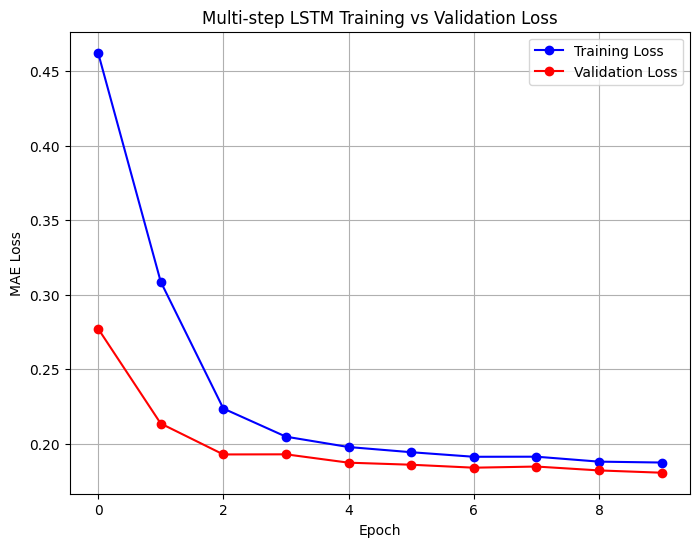

In [63]:
plot_train_history(train_losses, val_losses, "Multi-step LSTM Training vs Validation Loss")

학습 후 모델로 샘플 예측

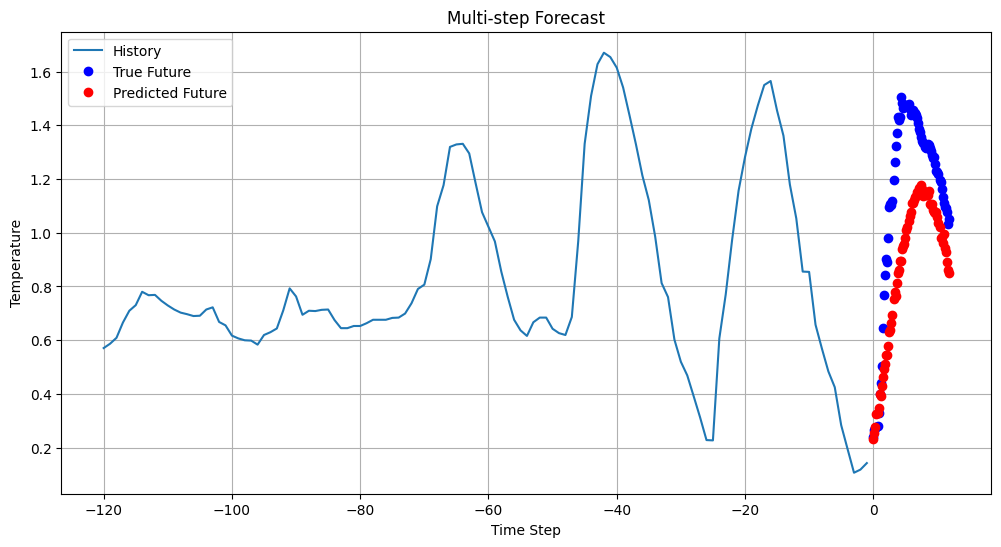

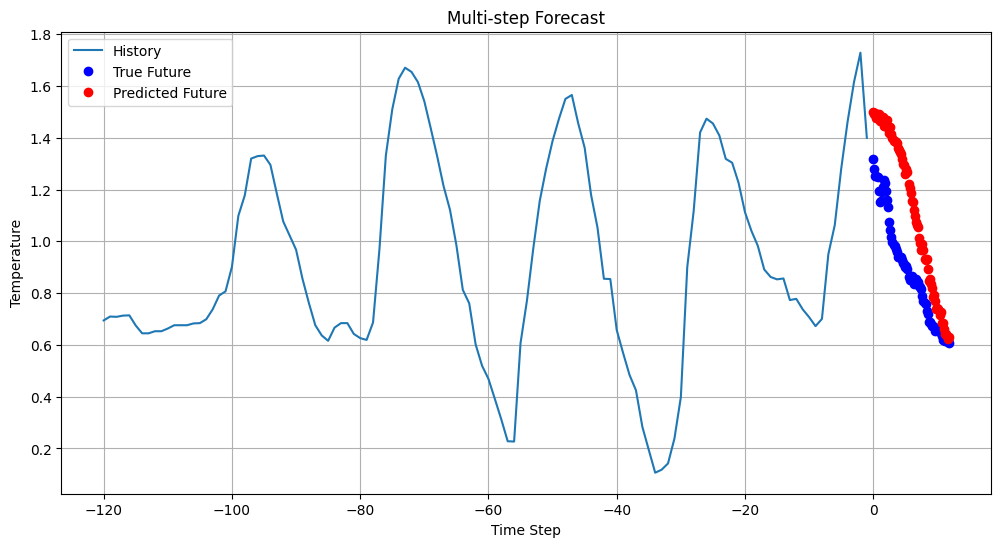

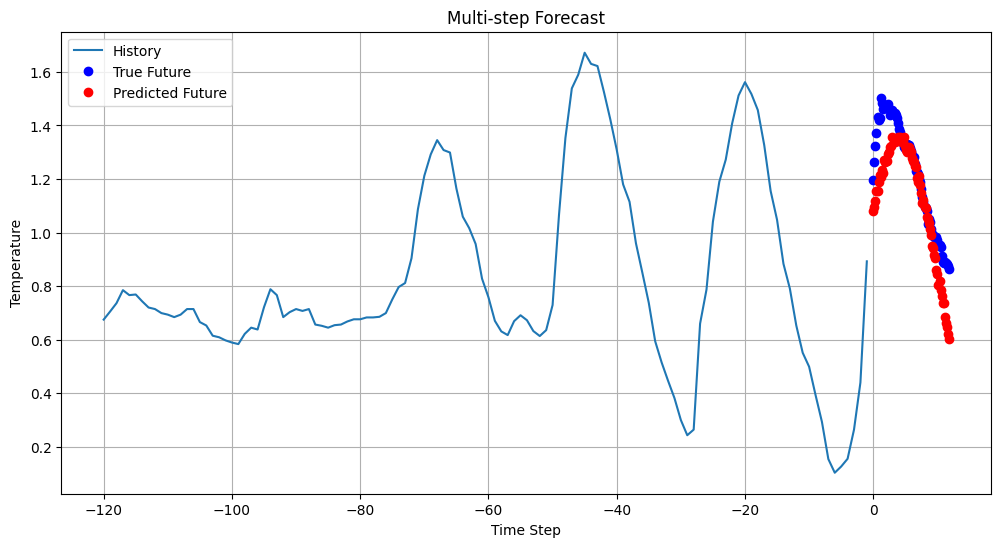

In [65]:
import random

with torch.no_grad():
    for x_batch, y_batch in val_loader_multi:
        indices = random.sample(range(x_batch.size(0)), 3)
        for i in indices:
            x_sample = x_batch[i]
            y_sample = y_batch[i]
            x_input = x_sample.unsqueeze(0)

            pred = model(x_input)[0].cpu().numpy()

            multi_step_plot(
                history=x_sample.cpu().numpy(),
                true_future=y_sample.cpu().numpy(),
                prediction=pred,
                step=STEP
            )
        break
